In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Start a graph session
sess = tf.Session()

In [3]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# Create directory if it doesn't exist
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [4]:
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

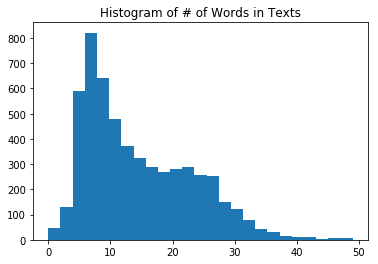

In [5]:
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [6]:
# Choose max text word length at 25
sentence_size = 25
min_word_freq = 3

In [7]:
# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get length of unique words.
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [8]:
# Split up data set into train/test
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [9]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

In [10]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [11]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 0.180391
Training Observation #20: Loss = 2.76706e-05
Training Observation #30: Loss = 0.00526619
Training Observation #40: Loss = 7.00048
Training Observation #50: Loss = 0.00339431
Training Observation #60: Loss = 0.505637
Training Observation #70: Loss = 3.16405
Training Observation #80: Loss = 5.39237
Training Observation #90: Loss = 0.466852
Training Observation #100: Loss = 2.82367
Training Observation #110: Loss = 0.00745451
Training Observation #120: Loss = 0.0140122
Training Observation #130: Loss = 3.29889
Training Observation #140: Loss = 0.0427034
Training Observation #150: Loss = 0.00772689
Training Observation #160: Loss = 0.00249959
Training Observation #170: Loss = 0.000436967
Training Observation #180: Loss = 0.376535
Training Observation #190: Loss = 0.213021
Training Observation #200: Loss = 1.16136
Training Observation #210: Loss = 0.00112768
Training Observation #220: Loss = 0.00144741
Training

Training Observation #1850: Loss = 0.128957
Training Observation #1860: Loss = 0.0389103
Training Observation #1870: Loss = 0.031009
Training Observation #1880: Loss = 0.0126438
Training Observation #1890: Loss = 0.00180414
Training Observation #1900: Loss = 0.0417961
Training Observation #1910: Loss = 0.00604415
Training Observation #1920: Loss = 4.54092
Training Observation #1930: Loss = 0.00528468
Training Observation #1940: Loss = 8.53164e-06
Training Observation #1950: Loss = 4.92538
Training Observation #1960: Loss = 0.644392
Training Observation #1970: Loss = 3.44282e-05
Training Observation #1980: Loss = 0.00474252
Training Observation #1990: Loss = 0.000612246
Training Observation #2000: Loss = 0.00768827
Training Observation #2010: Loss = 0.229222
Training Observation #2020: Loss = 0.00690201
Training Observation #2030: Loss = 0.00058377
Training Observation #2040: Loss = 2.96076e-05
Training Observation #2050: Loss = 0.000927855
Training Observation #2060: Loss = 0.00480891


Training Observation #3670: Loss = 0.0124383
Training Observation #3680: Loss = 0.0172527
Training Observation #3690: Loss = 0.0206617
Training Observation #3700: Loss = 0.0511689
Training Observation #3710: Loss = 0.00895875
Training Observation #3720: Loss = 0.0184341
Training Observation #3730: Loss = 0.00159335
Training Observation #3740: Loss = 0.411123
Training Observation #3750: Loss = 0.017687
Training Observation #3760: Loss = 0.000111034
Training Observation #3770: Loss = 0.00093805
Training Observation #3780: Loss = 0.0901999
Training Observation #3790: Loss = 0.00811726
Training Observation #3800: Loss = 0.517618
Training Observation #3810: Loss = 0.0018911
Training Observation #3820: Loss = 0.040755
Training Observation #3830: Loss = 0.0380624
Training Observation #3840: Loss = 0.153803
Training Observation #3850: Loss = 2.23055
Training Observation #3860: Loss = 0.00479686
Training Observation #3870: Loss = 0.00055802
Training Observation #3880: Loss = 0.0146699
Training 

In [13]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.8556053811659193


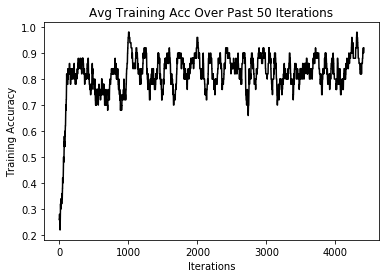

In [14]:
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()